I'll be using the same approach as I did for the aluminum question

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm 
import exchange_calendars as xcals

from lib import adf_test,  kpss_test

<AxesSubplot:>

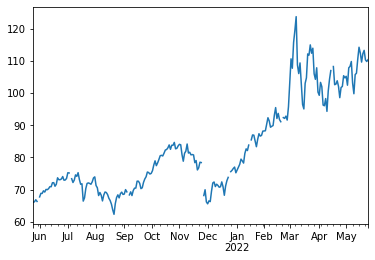

In [2]:
price_history = pd.read_csv('data/Crude Oil.csv')
business_day = xcals.get_calendar('NYSE').day
index = pd.PeriodIndex(price_history['Date'], freq=business_day)
price_history = price_history.set_index(index).sort_index()
price_history = price_history.reindex(pd.period_range(price_history.index[0], price_history.index[-1], freq=business_day))
price_history = price_history['Close'].sort_index()
price_history.plot()

In [3]:
adf_test(price_history)

Results of Dickey-Fuller Test:
Test Statistic                  -0.007867
p-value                          0.957877
#Lags Used                       8.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [4]:
kpss_test(price_history)

Results of KPSS Test:
Test Statistic            1.938596
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/jonah/.virtualenvs/infer-pub/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<AxesSubplot:>

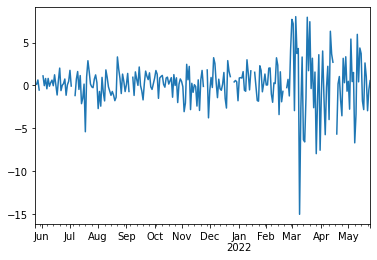

In [5]:
differenced = price_history.diff()
differenced.plot()

Whoa. The market got a lot more volatile in March. Let's assume that anything before the war in Ukraine won't be very informative.

<AxesSubplot:>

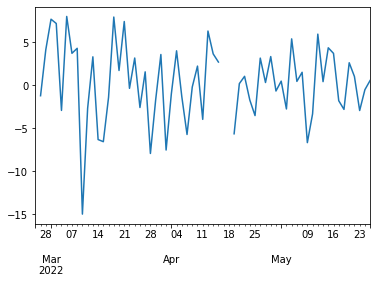

In [6]:
price_history = price_history.loc['2022-02-24':]
differenced = price_history.diff()
differenced.plot()

In [7]:
adf_test(differenced)

Results of Dickey-Fuller Test:
Test Statistic                -6.349810e+00
p-value                        2.627825e-08
#Lags Used                     7.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [8]:
kpss_test(differenced)

Results of KPSS Test:
Test Statistic           0.066314
p-value                  0.100000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/jonah/.virtualenvs/infer-pub/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


/home/jonah/.virtualenvs/infer-pub/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


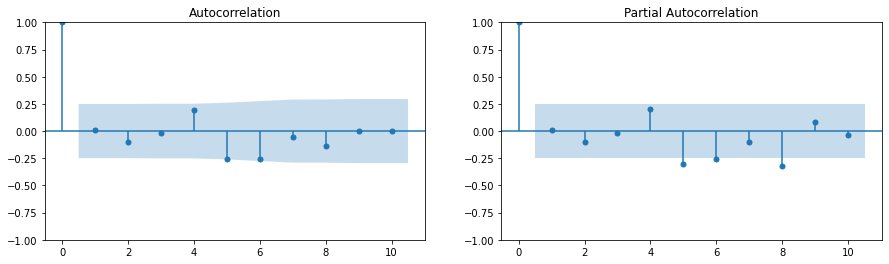

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(differenced.dropna(), lags=10, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(differenced.dropna(), lags=10, ax=axes[1])

In [10]:
model = sm.tsa.ARIMA(price_history, order=(1, 1, 0))
results = model.fit()
prediction_day = '2022-06-03'
forecast_results = results.get_forecast(prediction_day)
summary = forecast_results.summary_frame()
summary

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-05-26,110.341387,4.424738,101.669059,119.013715
2022-05-27,110.341619,6.321466,97.951774,122.731463
2022-05-30,110.341623,7.769174,95.114322,125.568925
2022-05-31,110.341623,8.986631,92.728150,127.955097
2022-06-01,110.341623,10.057784,90.628729,130.054518
2022-06-02,110.341623,11.025357,88.732320,131.950927
2022-06-03,110.341623,11.914612,86.989412,133.693835


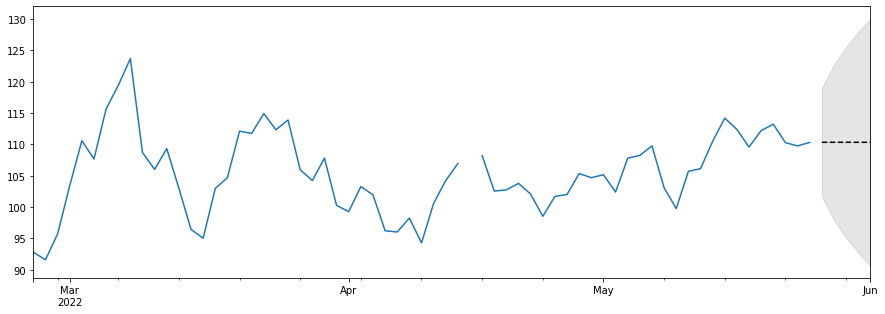

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
price_history.plot(ax=ax)
fcast = results.get_forecast('2022-06-01').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [12]:
mean = summary.loc[prediction_day]['mean']
se = summary.loc[prediction_day]['mean_se']
dist = norm(mean, se)
boundaries = [75, 90, 105, 120]
forecast = {f"Less than ${boundaries[0]}": dist.cdf(boundaries[0])}
for low, high in zip(boundaries, boundaries[1:]):
    forecast[f"More than or equal to ${low} but less than ${high}"] = dist.cdf(high) - dist.cdf(low)
forecast[f"More than or equal to ${boundaries[-1]}"] = 1 - dist.cdf(boundaries[-1])

{k: f'{round(100*v)}%' for k, v in forecast.items()}

{'Less than $75': '0%',
 'More than or equal to $75 but less than $90': '4%',
 'More than or equal to $90 but less than $105': '28%',
 'More than or equal to $105 but less than $120': '46%',
 'More than or equal to $120': '21%'}